In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import sympy as sy
import scipy.linalg as la 
import scipy.sparse.linalg as spla
import time 
import matplotlib.pyplot as plt
import cmath
from utils import helper
sy.init_printing()
%matplotlib inline

# The Arnoldi Iteration 

Use Krylov subspaces to find eigenvalues of extremely large matrices.



### Krylov Subspaces

The order-N Krylov subspace of A generated by x is 

$$\mathcal{K}_n(A,x) = span\{x, Ax, A^2x,...,A^{n-1}x\}$$

If the vectors $\{x, Ax, A^2x,...,A^{n-1}x\}$ are linearly independent, they form a basis for $\mathcal{K}_n(A,x)$. However, this basis is usually far from orthogonal, and hence computations using this basis will likely be ill-conditioned.

### Problem 1.

Using Algorithm 18.1, complete the following Python function that performs the Arnoldi iteration. Write this function so that it can run on complex arrays.

        def arnoldi(b, Amul, k, tol=1e-18):
            '''
            Perform `k` steps of the Arnoldi iteration on the linear operator 
            defined by `Amul`, starting with the vector `b`.
            
            Inputs: 
                b (ndarray): The starting vector for the iteration.
                Amul (function): A function handle that describes a linear 
                                operator
                k (int): The number of times to perform the iteration.
                tol (float): Stop iterating if the next vector in the iteration 
                             has norm less than `tol`. Defaults to 1e-8
            Returns: 
                H_n: (ndarray)
                Q_n: (ndarray)
                    The number n will equal k, unless the algorithm terminated
                    early, in which case n will be less than k.
                    
             Examples:
                 >>> A = np.array([[1,0,0], [0,2,0], [0,0,3]])
                 >>> Amul = lambda x: A.dot(x)
                 >>> H,Q = arnoldi(np.array([1,1,1]), Amul, 3)
                 >>> np.allclose(H, np.conjugate(Q.T).dot(A).dot(Q))
                 True
                 
                 >>> H,Q = arnoldi(np.array([1,0,0]), Amul, 3)
                 >>> H
                 array([[1.+0.j]])
                 >>> np.conjugate(Q.T).dot(A).dot(Q)
                 array([[1.+0.j]])
             '''
Hints:

1. Since `H` and `Q` will eventually hold complex numbers, initialize them as complex arrays (e.g., `A = np.empty((3,3), dtype=np.complex128)`).

2. Remember to use complex inner products.

3. This function can be tested on a matrix A by passing in `A.dot` for `Amul`

In [2]:
def arnoldi(b, Amul, k, tol=1e-18):
    '''
    Perform `k` steps of the Arnoldi iteration on the linear operator 
    defined by `Amul`, starting with the vector `b`.

    Inputs: 
        b (ndarray): The starting vector for the iteration.
        Amul (function): A function handle that describes a linear 
                        operator
        k (int): The number of times to perform the iteration.
        tol (float): Stop iterating if the next vector in the iteration 
                     has norm less than `tol`. Defaults to 1e-8
    Returns: 
        H_n: (ndarray)
        Q_n: (ndarray)
            The number n will equal k, unless the algorithm terminated
            early, in which case n will be less than k.

    Examples:
         >>> A = np.array([[1,0,0], [0,2,0], [0,0,3]])
         >>> Amul = lambda x: A.dot(x)
         >>> H,Q = arnoldi(np.array([1,1,1]), Amul, 3)
         >>> np.allclose(H, np.conjugate(Q.T).dot(A).dot(Q))
         True

         >>> H,Q = arnoldi(np.array([1,0,0]), Amul, 3)
         >>> H
         array([[1.+0.j]])
         >>> np.conjugate(Q.T).dot(A).dot(Q)
         array([[1.+0.j]])
    '''
    Q = np.empty((len(b), k+1), dtype=np.complex128)
    H = np.zeros((k+1, k), dtype=np.complex128)

    Q[:,0] = b/ np.linalg.norm(b)
    for j in range(k):
        Q[:, j+1] = Amul(Q[:,j])
        for i in range(j+1):
            H[i,j] = np.dot(Q[:,i].T, Q[:,j+1])
            Q[:,j+1] = Q[:,j+1] - H[i,j]*Q[:,i]
        H[j+1,j] = np.linalg.norm(Q[:,j+1])
        if np.abs(H[j+1,j])<tol:
            return H[:j+1,:j+1], Q[:,:j+1]
        Q[:,j+1] = Q[:,j+1]/H[j+1,j]
    return H[:-1,:],Q[:,:-1]

In [3]:
#check first if the function, H = Q_t*A*Q
A = np.array([[1,0,0], [0,2,0], [0,0,3]])
Amul = lambda x: A.dot(x)
H,Q = arnoldi(np.array([1,1,1]), Amul, 3)

np.allclose(H, np.conjugate(Q.T).dot(A).dot(Q))

True

In [4]:
#upper Hessenberg matrix
H

array([[  2.00000000e+00+0.j,   8.16496581e-01+0.j,   2.50446256e-15+0.j],
       [  8.16496581e-01+0.j,   2.00000000e+00+0.j,   5.77350269e-01+0.j],
       [  0.00000000e+00+0.j,   5.77350269e-01+0.j,   2.00000000e+00+0.j]])

In [5]:
#eigenvectors
Q

array([[  5.77350269e-01+0.j,  -7.07106781e-01+0.j,   4.08248290e-01+0.j],
       [  5.77350269e-01+0.j,  -2.71947991e-16+0.j,  -8.16496581e-01+0.j],
       [  5.77350269e-01+0.j,   7.07106781e-01+0.j,   4.08248290e-01+0.j]])

In [6]:
# now we will get the eigenvalue of A by computing the eigenvalue of H (upper Hessenberg matrix)
list(np.sort(la.eig(H)[0])[::-1])

[(3.0000000000000058+0j), (1.9999999999999989+0j), (1.0000000000000013+0j)]

In [7]:
#true eigenvalue of A, obviously, since A is a diagonal matrix
list(np.sort(la.eig(A)[0])[::-1])

[(3+0j), (2+0j), (1+0j)]

In [8]:
#run additional check, just copied from the test case example
H,Q = arnoldi(np.array([1,0,0]), Amul, 3)
print(H)
print(np.conjugate(Q.T).dot(A).dot(Q))
np.allclose(H, np.conjugate(Q.T).dot(A).dot(Q))

[[ 1.+0.j]]
[[ 1.+0.j]]


True

In [9]:
#how might the arnoldi iteration be advantageous?
A = np.random.random((500,500))
Amul = lambda x: A.dot(x)
b = np.ones(500)
H,Q = arnoldi(b, Amul,200)
np.allclose(H, np.conjugate(Q.T).dot(A).dot(Q))

True

In [10]:
#top 10 eigenvalues of H
num_eig = 10
list(np.sort(la.eig(H)[0])[::-1])[:num_eig]

[(250.2472113429661+0j),
 (6.4279685606655539-0.81644155173733945j),
 (6.4279685606655477+0.81644155173732436j),
 (6.2971491904899022-0.4186642021704749j),
 (6.2971491904898809+0.41866420217048267j),
 (6.1788474392387966-2.3306085276780539j),
 (6.1788474392387878+2.3306085276780402j),
 (6.0502658545838273-1.9318272089154893j),
 (6.0502658545838068+1.9318272089154918j),
 (5.95759657104258-0.92886364908065489j)]

In [11]:
#top 10 eigenvalues of A
list(np.sort(la.eig(A)[0])[::-1])[:num_eig]

[(250.24721134296595+0j),
 (6.4279685606544401+0.81644155173079935j),
 (6.4279685606544401-0.81644155173079935j),
 (6.29714919168409+0.41866420076465294j),
 (6.29714919168409-0.41866420076465294j),
 (6.1788474392389627+2.3306085276778927j),
 (6.1788474392389627-2.3306085276778927j),
 (6.0502658546226318+1.9318272088382911j),
 (6.0502658546226318-1.9318272088382911j),
 (5.9575999334295684+0.92886648891551438j)]

In [12]:
#what if the initial vector is the eigenvector, what does H look like?
A = np.eye(5)
b = np.array([1,0,0,0,0])
Amul = lambda x: A.dot(x)
H,Q = arnoldi(b, Amul, 3)
np.allclose(H, np.conjugate(Q.T).dot(A).dot(Q))

True

In [13]:
H

array([[ 1.+0.j]])

In [41]:
#arnoldi iteration in numpy
A = np.array([[1,0,0], [0,2,0], [0,0,3]], dtype="float")
b = np.array([1,1,1])
spla.eigs(A, v0=b, k = 1) #k should be less than dim(A)-1

(array([ 3.+0.j]), array([[ -3.43830161e-16+0.j],
        [ -5.18951220e-16+0.j],
        [ -1.00000000e+00+0.j]]))

### Problem 2. 

Finish the following function that computes the Ritz values of a matrix.

        def ritz(Amul, dim, k, iters):
            '''
            Inputs: 
                Amul (function): A function describing a linear operator on R^(dim).
                dim (int): The dimension of the space on which `Amul` acts.
                k (int): The number of Ritz values to return.
                iters (int): The number of times to perform the Arnoldi iteration.
                    Must be between `k` and `dim`
            '''

In [15]:
def ritz(Amul, dim, k, iters):
    '''
    Inputs: 
        Amul (function): A function describing a linear operator on R^(dim).
        dim (int): The dimension of the space on which `Amul` acts.
        k (int): The number of Ritz values to return.
        iters (int): The number of times to perform the Arnoldi iteration.
            Must be between `k` and `dim`
    '''
    b = np.random.random(dim)
    H,Q = arnoldi(b, Amul, iters)
    return la.eig(H)[0][:k]

In [42]:
list(np.sort(la.eig(A)[0])[::-1])

[(3+0j), (2+0j), (1+0j)]

In [17]:
list(np.sort(ritz(Amul, len(A), 3, 7))[::-1])

[(3.0000000000000009+0j), (1.9999999999999989+0j), (1.0000000000000009+0j)]

### Problem 3.
The four largest eigenvalues of the Fast Fourier Transform are known to be ${-\sqrt{N},\sqrt{N},-i\sqrt{N},i\sqrt{N}}$ where $N$ is the dimension of the space on which the transform acts. Use your function `ritz()` from Problem 2 to approximate the eigenvalues of the Fast Fourier Transform. Set `k` to be $10$ and set `dim` to be $2^{20}$. For the argument $Amul$, use the `fft` function from `scipy.fftpack`.

In [18]:
from scipy.fftpack import fft

In [19]:
Amul = lambda x: fft(x)
k = 10
dim = 2**20

ritz_vals = ritz(Amul, dim, k, iters=30)

In [20]:
list(np.around(ritz_vals))

[(-4460+1861j),
 (-3408-451j),
 (-1024-0j),
 (-2367-1904j),
 (-2156+2469j),
 (-1499-2482j),
 (-0-1024j),
 (1024+0j),
 (-0+1024j),
 (3395-572j)]

In [21]:
#four largest eigenvalues of the Fast Fourier Transform
eigs = np.array([-np.sqrt(dim),
                 np.sqrt(dim),
                 -1j*np.sqrt(dim),
                 1j*np.sqrt(dim)])
list(eigs)

[(-1024+0j), (1024+0j), -1024j, 1024j]

### Problem 4.
Finish the following function to visualize the convergence of the Ritz values.

        def plot_ritz(A, n, iters):
        """Plot the relative error of the Ritz values of ￿A'. Use the number
                 of
            iterations as the x-axis and the relative error of the Ritz values of
                 H_k
            a approximations to the eigenvalues of A as the y-axis.
            Inputs:
                A (ndarray)
            n (int): The number of Ritz values to plot.
            iters (int): The number of times to perform the Arnoldi iteration.
        """
        
If $\tilde{x}$ is an an approximation to $x$, then the absolute error in the approximation is

$$\frac{||x - \tilde{x}||}{||x||}$$

￼Hint: The most difficult part of this problem is to identify which Ritz values correspond to which eigenvalues. After finding the Ritz values (or eigenvalues) of largest magnitude, use np.sort() to put them in order. Make sure that this order is preserved throughout your program.


It may help to use the following algorithm.

1. Find $n$ eigenvalues of $A$ of largest magnitude. Store these in order.
2. Create an empty array to store the relative errors. For every $k \epsilon $`[1, iters)`,

    (a) Compute $H_k$ with the Arnoldi iteration.

    (b) Find $n$ eigenvalues of $A$ of largest magnitude. Note that for small `k`, the matrix $H_k$ may not have this many eigenvalues.

    (c) Store the absolute error. Make sure that the errors are stored in the correct order. For small `k`, some entries in the row or column may not be used.

3. Use array broadcasting to compute the absolute error.

4. Iteratively plot the errors. Lines for distinct eigenvalues should start at different places on the x-axis.

Run your function on these examples. The plots should be fairly similar to `Figures 18.1b and 18.1a`.

￼
    >>> # A matrix with random entries
    >>> A = np.random.rand(300, 300)
    >>> plot_ritz(A, 10, 175)
    >>>
    >>> # A matrix with uniformly distributed eigenvalues
    >>> D = np.diag(np.random.rand(300))
    >>> B = A.dot( D.dot(la.inv(A)) )
    >>> plot_ritz(B, 10, 175)
    
If your code takes too long to run, consider integrating your solutions to Problems 1 and 2 with the body of this function.

In [22]:
def plot_ritz(A, n, iters):
    """
    Plot the relative error of the Ritz values of `A`. Use the number of
    iterations as the x-axis and the relative error of the Ritz values of
    H_k a approximations to the eigenvalues of A as the y-axis.
    Inputs:
            A (ndarray)
    n (int): 
            The number of Ritz values to plot.
    iters (int):
            The number of times to perform the Arnoldi iteration.
    """
    Amul = lambda x: A.dot(x)
    true_eig = np.sort(la.eig(A)[0])[::-1]
    
    errors = []
    for i in range(1,iters):
        ritz_values = np.sort(ritz(Amul, len(A), min((n,i)), i))[::-1]
        error = np.abs(true_eig[:len(ritz_values)] - ritz_values)/np.abs(true_eig[:len(ritz_values)])
        errors.append(error)
    errors = np.array(errors)
    
    #for i in range(errors.shape[1]):
    #    plt.plot(np.arange(iters), errors[:,i])
    
    for i in range(n):
        plt.plot(np.arange(i,iters-1), [error[i] for error in errors[i:]])
    return errors

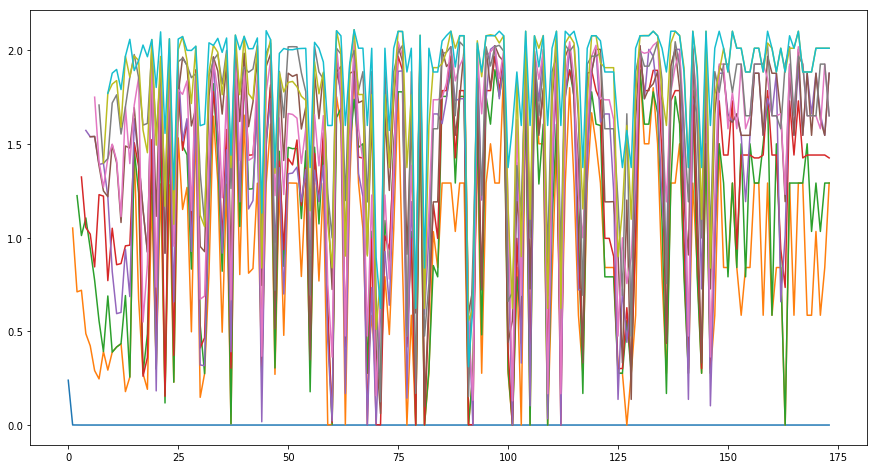

In [23]:
# A matrix with random entries
plt.figure(figsize=(15,8))
A = np.random.rand(300, 300)
errors1 = plot_ritz(A, 10, 175)

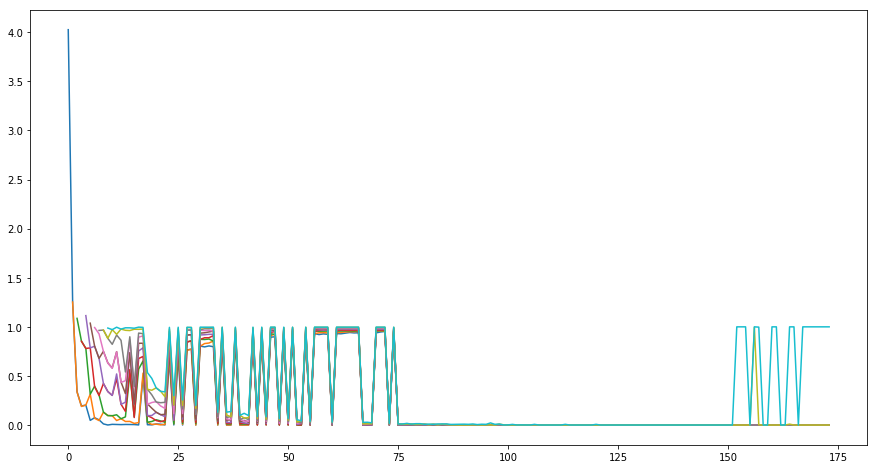

In [24]:
plt.figure(figsize=(15,8))
D = np.diag(np.random.rand(300))
B = A.dot( D.dot(la.inv(A)) )
errors2 = plot_ritz(B, 10, 175)

## Lanczos Iteration

The Lanczos iteration is a version of the Arnoldi iteration that is optimized to operate on symmetric matrices. If A is symmetric, then it shows that $H_k$ is symmetric and hence tridiagonal. This leads to two simplifications of the Arnoldi algorithm.


First, we have $0 = H_{k,n} = \langle \textbf{q}_{k}, A \textbf{q}_{n}\rangle$ for $k \leq n-2$; i.e., $A\textbf{q}_n$ is orthogonal to $\textbf{q}_1,...,\textbf{q}_{n-2}$. Thus, if the goal is only to compute $H_k$ (say to find the Ritz values), then we only need to store the two most recently computed columns of $Q$.

Second, the data of $H_k$ can also be stored in two vectors, one containing the main diagonal and one containing the first subdiagonal of $H_k$.

### Problem 5. 
Implement Algorithm 18.2 by completing the following function. Write it so that it can operate on complex arrays.
        
        def lanczos(b, Amul, k, tol=1E-8):
            """
            Perform `k` steps of the Lanczos iteration on the symmetric linear operator defined by 
            `Amul`, starting with the vector `b`.
            INPUTS:
                b    - A NumPy array. The starting vector for the Lanczos iteration.
                Amul - A function handle. Should describe a symmetric linear operator.
                k    - Number of times to perform the Lanczos iteration.
                tol  - Stop iterating if the next vector in the Lanczos iteration has
                norm less than `tol`. Defaults to 1E-8.
            RETURN:
            Return (alpha, beta) where alpha and beta are the main diagonal and first subdiagonal of the tridiagonal 
            matrix computed by the Lanczos iteration.
            '''

In [25]:
def lanczos(b, Amul, k, tol=1E-8):
    """
    Perform `k` steps of the Lanczos iteration on the symmetric linear operator defined by 
    `Amul`, starting with the vector `b`.
    INPUTS:
        b    - A NumPy array. The starting vector for the Lanczos iteration.
        Amul - A function handle. Should describe a symmetric linear operator.
        k    - Number of times to perform the Lanczos iteration.
        tol  - Stop iterating if the next vector in the Lanczos iteration has
        norm less than `tol`. Defaults to 1E-8.
    RETURN:
    Return (alpha, beta) where alpha and beta are the main diagonal and first subdiagonal of the tridiagonal 
    matrix computed by the Lanczos iteration.
    """
    
    q0 = np.zeros(len(b))
    q1 = b/ np.linalg.norm(b)
    x = np.empty(k, dtype="complex")
    y = np.empty(k, dtype="complex")
    for i in range(0,k):
        z = Amul(q1)
        x[i] = np.dot(q1, z)
        z = z - x[i]*q1 - y[i-1]*q0
        y[i] = np.linalg.norm(z)
        if y[i]<tol:
            return x[:i+1],y[:i]
        z = z/y[i]
        q0,q1 = q1,z
    return x, y[:-1]

In [26]:
A = np.random.random((5,5))
A = np.dot(A,A.T) #matrix has to be symmetric

b = np.random.random(5)
k = 5
tol = 1e-8

In [27]:
#computation of Hessenberg matrix using Lanczos iteration
Amul = lambda x: A.dot(x)
diag, subdiag = lanczos(b, Amul, k)

In [28]:
H_lanczos = (np.diag(diag)+ np.diag(subdiag, k=1))+np.diag(subdiag, k=-1)
print(np.diag(H_lanczos, k=0))
print(np.diag(H_lanczos, k=1))

[ 4.68682162+0.j  1.41904133+0.j  0.52487841+0.j  0.59089737+0.j
  0.13181805+0.j]
[ 2.53816754+0.j  0.10690024+0.j  0.32836108+0.j  0.06819322+0.j]


In [29]:
np.around(H_lanczos, 4)

array([[ 4.6868+0.j,  2.5382+0.j,  0.0000+0.j,  0.0000+0.j,  0.0000+0.j],
       [ 2.5382+0.j,  1.4190+0.j,  0.1069+0.j,  0.0000+0.j,  0.0000+0.j],
       [ 0.0000+0.j,  0.1069+0.j,  0.5249+0.j,  0.3284+0.j,  0.0000+0.j],
       [ 0.0000+0.j,  0.0000+0.j,  0.3284+0.j,  0.5909+0.j,  0.0682+0.j],
       [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0682+0.j,  0.1318+0.j]])

In [30]:
Amul = lambda x: A.dot(x)
H_arnoldi,Q = arnoldi(b, Amul, k)

In [31]:
print(np.diag(H_arnoldi, k=0))
print(np.diag(H_arnoldi, k=1))

[ 4.68682162+0.j  1.41904133+0.j  0.52487841+0.j  0.59089737+0.j
  0.13181805+0.j]
[ 2.53816754+0.j  0.10690024+0.j  0.32836108+0.j  0.06819322+0.j]


In [32]:
np.around(H_arnoldi, 4)

array([[ 4.6868+0.j,  2.5382+0.j,  0.0000+0.j, -0.0000+0.j,  0.0000+0.j],
       [ 2.5382+0.j,  1.4190+0.j,  0.1069+0.j, -0.0000+0.j,  0.0000+0.j],
       [ 0.0000+0.j,  0.1069+0.j,  0.5249+0.j,  0.3284+0.j, -0.0000+0.j],
       [ 0.0000+0.j,  0.0000+0.j,  0.3284+0.j,  0.5909+0.j,  0.0682+0.j],
       [ 0.0000+0.j,  0.0000+0.j,  0.0000+0.j,  0.0682+0.j,  0.1318+0.j]])

In [33]:
#check if both Hessenberg matrices are equal
print(np.allclose(H_lanczos, H_arnoldi))

True


### Problem 6.

The following code performs multiplication by a tridiagonal symmetric matrix.

        def tri_mul(a, b, u):
            ''' 
            Return Au where A is the tridiagonal symmetric matrix with main diagonal a and subdiagonal b.
            '''
            
            v=a*u
            v[:-1] += b * u[1:] 
            v[1:] += b * u[:-1] 
            return v
            
Let A be a $1000 \times 1000$ symmetric tridiagonal matrix with random values in its nonzero diagonals. Use the function lanczos() from Problem 5 with 100 iterations to estimate the 5 eigenvalues of A of largest norm. Compare these to the 5 largest true eigenvalues of A.

If you do this problem for different vectors a and b, you may notice that occasionally the largest Ritz value is repeated. This happens because the vectors used in the Lanczos iteration may not be orthogonal. These erroneous eigenvalues are called “ghost eigenvalues.”

In [34]:
def tri_mul(a, b, u):
    ''' 
    Return Au where A is the tridiagonal symmetric matrix with main diagonal a and subdiagonal b.
    '''

    v=a*u
    v[:-1] += b * u[1:] 
    v[1:] += b * u[:-1] 
    return v

In [35]:
n = 1000
diag_main = np.random.random(n)
diag_sub = np.random.random(n-1)

A = np.diag(diag_main, k=0)+np.diag(diag_sub, k=1)+np.diag(diag_sub, k=-1)
b = np.random.random(n)
k = 500

In [36]:
#let's first compute the top 5 largest eignevalues of A
np.sort(la.eig(A)[0])[::-1][:5]

array([ 2.33806475+0.j,  2.26263383+0.j,  2.20617165+0.j,  2.19914294+0.j,
        2.18626770+0.j])

In [37]:
#compute the H matrix using Lanczos iteration
tri_mul_wrapper = lambda x: tri_mul(a=diag_main, b=diag_sub, u=x)
x,y=lanczos(b, tri_mul_wrapper, k=k)
H_lanczos = np.diag(x, k=0)+np.diag(y, k=1)+np.diag(y,k=-1)

In [38]:
#the top 20 eigenvalues of H matrix using the Lanczos iteration
np.sort(la.eig(H_lanczos)[0])[::-1][:20]

array([ 2.33806475+0.j,  2.33806475+0.j,  2.33806475+0.j,  2.33806475+0.j,
        2.33806475+0.j,  2.33806475+0.j,  2.33806475+0.j,  2.26263383+0.j,
        2.26263383+0.j,  2.26263383+0.j,  2.26263383+0.j,  2.26263383+0.j,
        2.26263383+0.j,  2.20617165+0.j,  2.20617165+0.j,  2.20617165+0.j,
        2.20617165+0.j,  2.19914294+0.j,  2.19914294+0.j,  2.19914294+0.j])

In [39]:
#numerically stable lanczos iteration using scipy.sparse.linalg.eigsh()
np.sort(spla.eigsh(A, k=5)[0])[::-1]

array([ 2.33806475,  2.26263383,  2.20617165,  2.19914294,  2.1862677 ])